# Handwritten Character Sequence Detection using OpenCv and CNN Tensorflow model
The purpose of this notebook is to anwser at one problem, one question : Can we recognize handwritten sequence character using a Deep learning algorithm. There is many exemple of Digit Character recogniction using the MNIST dataset. But how we can adapt this for not only digits (for characters too) and for an sequence. 

### The libraries we would use

In [14]:
import cv2
import imutils
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

print("Import of OpenCV :", cv2.__version__)
print("Import of Image Utils :", imutils.__version__)
print("Import of Numpy :", np.__version__)
print("Import of Tensorflow :", tf.__version__)

Import of OpenCV : 4.5.3
Import of Image Utils : 0.5.4
Import of Numpy : 1.21.2
Import of Tensorflow : 2.7.0


In [15]:
def order_points(pts):
	rect = np.zeros((4, 2), dtype = "float32")
	s = pts.sum(axis = 1)
	rect[0] = pts[np.argmin(s)]
	rect[2] = pts[np.argmax(s)]
	diff = np.diff(pts, axis = 1)
	rect[1] = pts[np.argmin(diff)]
	rect[3] = pts[np.argmax(diff)]
	return rect

def four_point_transform(image, pts):
	rect = order_points(pts)
	(tl, tr, br, bl) = rect
	widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
	widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
	maxWidth = max(int(widthA), int(widthB))
	heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
	heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
	maxHeight = max(int(heightA), int(heightB))
	dst = np.array([
		[0, 0],
		[maxWidth - 1, 0],
		[maxWidth - 1, maxHeight - 1],
		[0, maxHeight - 1]], dtype = "float32")
	M = cv2.getPerspectiveTransform(rect, dst)
	warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
	return warped

### We load the image who contains the handwritten character sequence to detect

In [166]:
img_path = "images/sequence.jpeg"
# img_path = "img/aaa.jpeg"


image = cv2.imread(img_path)
img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# img_gray = 255 - img_gray
blurred = cv2.GaussianBlur(img_gray, (5, 5), 0)
edged = cv2.Canny(blurred, 50, 200, 255)
ret, thresh = cv2.threshold(img_gray, 150, 255, cv2.THRESH_BINARY)

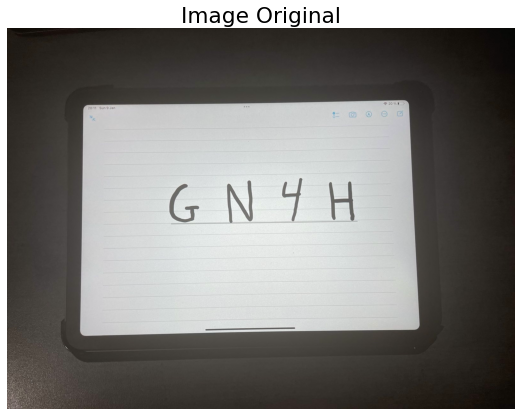

In [167]:
fig = plt.figure(figsize=(12,7))
grid = gridspec.GridSpec(ncols=1,nrows=1,figure = fig)
plt.axis(False)
plt.title("Image Original")
plt.imshow(image)

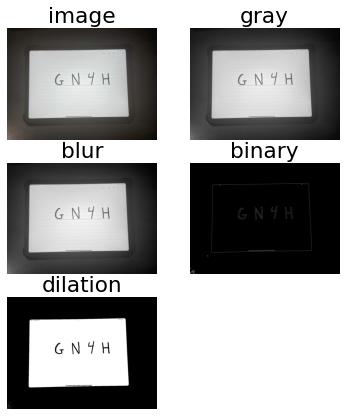

In [150]:
fig = plt.figure(figsize=(6,7))
plt.rcParams.update({"font.size":18})
grid = gridspec.GridSpec(ncols=2,nrows=3,figure = fig)
plot_image = [image, img_gray, blurred, edged,thresh]
plot_name = ["image","gray","blur","binary","dilation"]

for i in range(len(plot_image)):
    fig.add_subplot(grid[i])
    plt.axis(False)
    plt.title(plot_name[i])
    if i ==0:
        plt.imshow(plot_image[i])
    else:
        plt.imshow(plot_image[i],cmap="gray")

In [151]:
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

displayCnt = None
for c in cnts:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    if len(approx) == 4:
        displayCnt = approx
        break

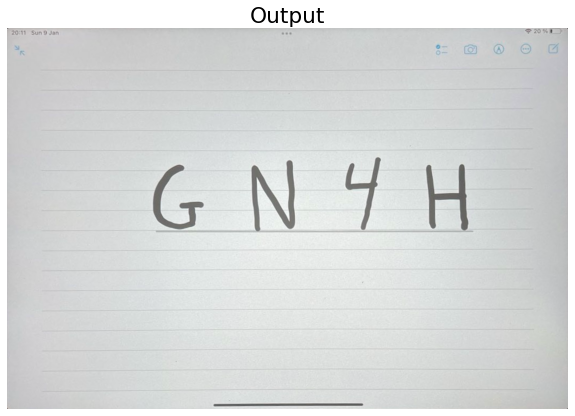

In [152]:
try:
    output = four_point_transform(image, displayCnt.reshape(4, 2))
except Exception as e:
    print("not transform")
    output = image
# output = image
fig = plt.figure(figsize=(12,7))
grid = gridspec.GridSpec(ncols=1,nrows=1,figure = fig)
plt.axis(False)
plt.title("Output")
plt.imshow(output)

In [153]:
img_gray = cv2.cvtColor(output, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(img_gray, (5, 5), 0)
edged = cv2.Canny(blurred, 50, 200, 255)
ret, thresh_output = cv2.threshold(output, 150, 255, cv2.THRESH_BINARY)
kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
thre_mor = cv2.morphologyEx(thresh_output, cv2.MORPH_DILATE, kernel3)


In [154]:
contours, hierarchy = cv2.findContours(image=edged, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)

In [155]:
def sort_contours(cnts,reverse = False):
    i = 0
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
                                        key=lambda b: b[1][i], reverse=reverse))
    return cnts

In [158]:
# creat a copy version "test_roi" of plat_image to draw bounding box
test_roi = output.copy()

# Initialize a list which will be used to append charater image
crop_characters = []

# define standard width and height of character
digit_w, digit_h = 28, 28

count = 0
last_x, last_y = 0,0
for c in sort_contours(contours):
    (x, y, w, h) = cv2.boundingRect(c)
    ratio = h/w
    if 1<=ratio<=3.5:
        if h/output.shape[0]>=0.1:
            print("x =", x, ",y =", y, ",w =", w, ",h =", h)
            # if x != last_x and y != last_y:
            if (x > last_x + 20 or x < last_x - 20) and (x > last_y + 20 or x < last_y - 20):
                count = count + 1
                # Draw bounding box arroung digit number
                cv2.rectangle(test_roi, (x-30, y-30), (x + w +30, y + h + 30), (0, 255,0), 2)

                # Sperate number and gibe prediction
                curr_num = output[y-30:y+h+30,x-30:x+w+30]
                curr_num = cv2.resize(curr_num, dsize=(digit_w, digit_h))
                _, curr_num = cv2.threshold(curr_num, 150, 255, cv2.THRESH_BINARY)
                crop_characters.append(curr_num)
            last_x, last_y = x, y
            
print("number of character :", count)

x = 275 ,y = 258 ,w = 97 ,h = 122
x = 275 ,y = 258 ,w = 97 ,h = 122
x = 462 ,y = 259 ,w = 71 ,h = 126
x = 473 ,y = 249 ,w = 72 ,h = 130
x = 639 ,y = 244 ,w = 68 ,h = 137
x = 639 ,y = 244 ,w = 68 ,h = 137
x = 792 ,y = 257 ,w = 80 ,h = 125
x = 792 ,y = 257 ,w = 80 ,h = 125
number of character : 4


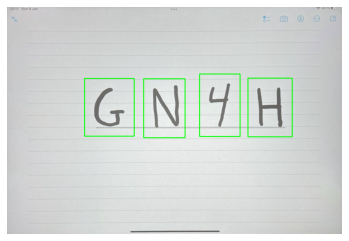

In [159]:
fig = plt.figure(figsize=(6,7))
plt.rcParams.update({"font.size":18})
grid = gridspec.GridSpec(ncols=1,nrows=1,figure = fig)
plot_image = test_roi
plt.axis(False)
plt.imshow(plot_image)

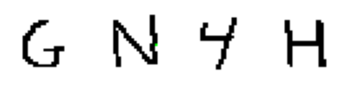

In [160]:
fig = plt.figure(figsize=(6,7))
plt.rcParams.update({"font.size":18})
grid = gridspec.GridSpec(ncols=len(crop_characters),nrows=1,figure = fig)
plot_image = crop_characters

for i in range(len(plot_image)):
    fig.add_subplot(grid[i])
    plt.axis(False)
    plt.imshow(plot_image[i])

In [161]:
x = []
for img in crop_characters: 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.GaussianBlur(img, (5, 5), 0)
    img = cv2.resize(img, (28,28))
    img = 255 - img
    # img = img/255.0
    x.append(img)

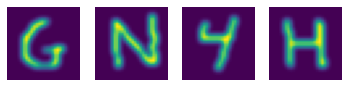

In [162]:
fig = plt.figure(figsize=(6,7))
plt.rcParams.update({"font.size":18})
grid = gridspec.GridSpec(ncols=len(crop_characters),nrows=1,figure = fig)
plot_image = crop_characters

for i in range(len(x)):
    fig.add_subplot(grid[i])
    plt.axis(False)
    plt.imshow(x[i])

In [163]:
from tensorflow.keras.preprocessing import image  

pred = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A' ,'B', 'C', 'D', 'E', 'F', 'G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','a','b','d','e','f','g','h','n','q','r','t']

from tensorflow import keras
model = keras.models.load_model('EMNIST.h5')

result = ""
for i in x:
    img_6 = i
    img_6 = image.img_to_array(img_6)
    # img_6 = img_6.flatten()
    img_6 = np.expand_dims(img_6, axis=0)
    prediction = model.predict(img_6)  # predict
    result = result + str(pred[np.argmax(prediction)])
print(result)


GN4H


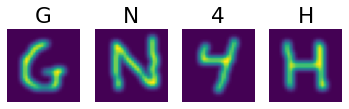

In [165]:
fig = plt.figure(figsize=(6,7))
plt.rcParams.update({"font.size":18})
grid = gridspec.GridSpec(ncols=len(crop_characters),nrows=1,figure = fig)
plot_image = crop_characters

for i in range(len(plot_image)):
    fig.add_subplot(grid[i])
    plt.axis(False)
    plt.title(result[i])
    plt.imshow(x[i])